# Projet de mention

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## ε-greedy algorithm on a 10-arm bandit problem

In [2]:
class Bandit:
    def __init__(self, k=10):
        self.k = k
        self.action_value = np.random.normal(0, 1, k)
    
    def pull(self, arm):
        return np.random.normal(self.action_value[arm], 1)
    
    def optimal_arm(self):
        return np.argmax(self.action_value)

class AgentEpsilonGreedy:
    def __init__(self, k=10, epsilon=0.1):
        self.k = k
        self.epsilon = epsilon
        self.estimated_action_value = np.zeros(k)
        self.action_count = np.zeros(k)
    
    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.k)
        else:
            return np.argmax(self.estimated_action_value)
    
    def update_values(self, arm, reward):
        self.estimated_action_value[arm] = (self.estimated_action_value[arm]*self.action_count[arm] + reward)/(self.action_count[arm]+1)
        self.action_count[arm] += 1

def simulate(bandit, agent, steps):
    rewards = np.zeros(steps)
    optimal_action = np.zeros(steps)
    optimal_arm = bandit.optimal_arm()
    for n in range(steps):
        arm = agent.select_action()
        reward = bandit.pull(arm)
        agent.update_values(arm, reward)
        rewards[n] = reward
        optimal_action[n] = arm == optimal_arm
    return rewards, optimal_action

n_simulation = 1000
steps = 2000
list_epsilon = np.array([0.01, 0.05, 0.1, 0.2])
all_rewards = np.zeros((n_simulation, steps, list_epsilon.size))
all_optimal_arm = np.zeros((n_simulation, steps, list_epsilon.size))
for i in range(list_epsilon.size):
    for k in range(n_simulation):
        agent = AgentEpsilonGreedy(epsilon=list_epsilon[i])
        bandit = Bandit()
        [all_rewards[k,:,i], all_optimal_arm[k,:,i]] = simulate(bandit,agent,steps)

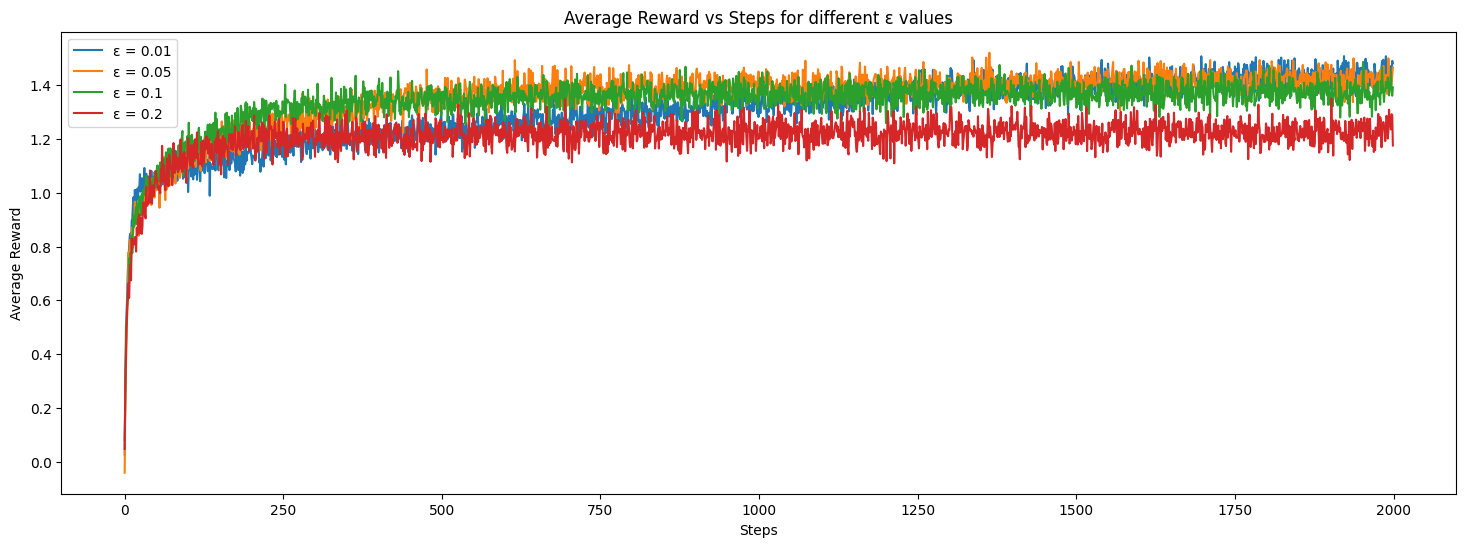

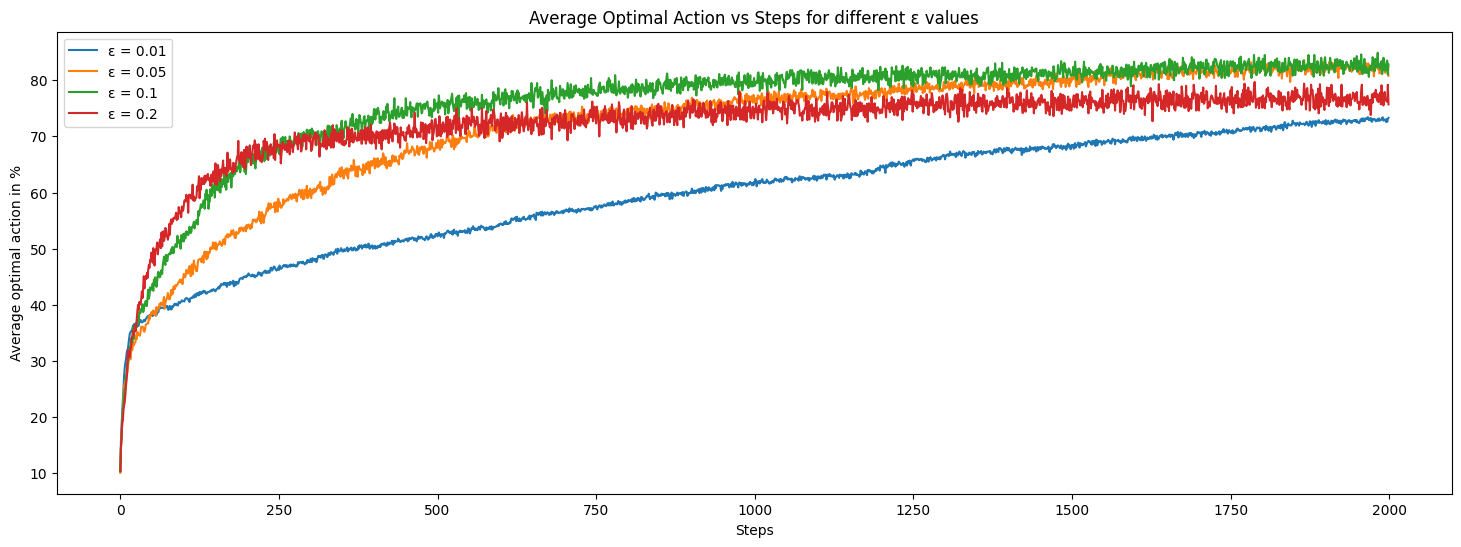

In [3]:
average_reward_greedy = all_rewards.mean(0)
plt.figure(figsize=(18, 6))
for i, epsilon in enumerate(list_epsilon):
    plt.plot(average_reward_greedy[:, i], label=f'ε = {epsilon}')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Steps for different ε values')
plt.legend()
plt.show()

average_optimal_arm = all_optimal_arm.mean(0)
plt.figure(figsize=(18, 6))
for i, epsilon in enumerate(list_epsilon):
    plt.plot(average_optimal_arm[:, i]*100, label=f'ε = {epsilon}')
plt.xlabel('Steps')
plt.ylabel('Average optimal action in %')
plt.title('Average Optimal Action vs Steps for different ε values')
plt.legend()
plt.show()

## UCB

The action selection function here is:
$$
A_t = \argmax_a \left[Q_t(a) +c \sqrt{\frac{\ln(t)}{N_t(a)}} \right]
$$

Where
- $a$ is the action we consider
- $Q_t(a)$ is the estimated value function of the action $a$ at the step $t$
- $N_t(a)$ is the number of times the action $a$ got selected by the agent
- $A_t$ is the action to take at the instant $t$

In [4]:
class AgentUCB:
    def __init__(self, k=10, c=2):
        self.k = k
        self.c = c
        self.estimated_action_value = np.zeros(k)
        self.action_count = np.zeros(k)
        self.estimates_and_uncertainties = np.zeros(k)
    
    def select_action(self):
        return self.estimates_and_uncertainties.argmax()
    
    def update_values(self, arm, reward, t):
        self.estimated_action_value[arm] += (reward - self.estimated_action_value[arm])/(self.k + 1e-5)
        self.action_count[arm] += 1
        self.estimates_and_uncertainties = self.estimated_action_value + (self.c * np.sqrt(np.log(np.ones(self.k)*(t+1))/(self.action_count + 1)))

def simulateUCB(bandit, agent, steps):
    rewards = np.zeros(steps)
    optimal_action = np.zeros(steps)
    optimal_arm = bandit.optimal_arm()
    for n in range(steps):
        arm = agent.select_action()
        reward = bandit.pull(arm)
        agent.update_values(arm, reward, n)
        rewards[n] = reward
        optimal_action[n] = arm == optimal_arm
    return rewards, optimal_action

n_simulation = 1000
steps = 1000
c = 1
all_rewards_ucb = np.zeros((n_simulation, steps))
all_optimal_arm_ucb = np.zeros((n_simulation, steps))
for k in range(n_simulation):
    agent = AgentUCB(10, c)
    bandit = Bandit(10)
    [all_rewards_ucb[k, :], all_optimal_arm_ucb[k, :]] = simulateUCB(bandit, agent, steps)


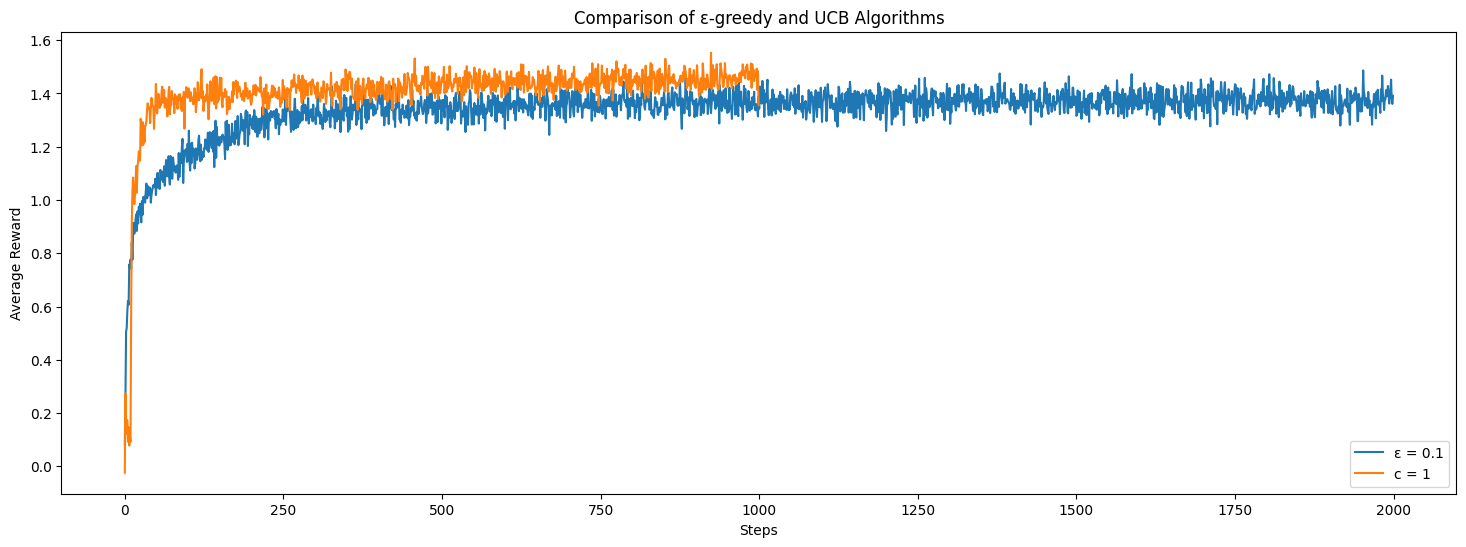

In [5]:
average_reward_ucb = all_rewards_ucb.mean(0)
plt.figure(figsize=(18, 6))
plt.plot(average_reward_greedy[:, 2], label=f'ε = 0.1')
plt.plot(average_reward_ucb, label=f'c = {c}')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Comparison of ε-greedy and UCB Algorithms')
plt.legend()
plt.show()

## Gradient Bandit

The action selection function here is:
$$
A_t = \argmax_a\pi_t(a) \quad , \ \text{ where } \pi_t(a) = Pr(A_t = a) = \frac{e^{H_t(a)}}{\sum^{n}_{b=1}e^{H_t(b)}}
$$
And $H_t$ is incremented or decremented at each step by the difference of the actual reward and its overall mean.

In [6]:
class Bandit_shifted:
    def __init__(self, k=10, mean=4):
        self.k = k
        self.mean = mean
        self.action_value = np.random.normal(self.mean, 1, k)
    
    def pull(self, arm):
        return np.random.normal(self.action_value[arm], 1)
    
    def optimal_arm(self):
        return np.argmax(self.action_value)
    
class Agent_gradient_bandit:
    def __init__(self, k=10, alpha=0.1):
        self.k = k
        self.alpha = alpha
        self.preferences = np.zeros(k)
        self.baseline = 0
        self.probabilities = np.ones(k)*1/k
        
    def select_action(self):
        return np.random.choice(self.k, p=self.probabilities)
    
    def update_values(self, arm, reward, t):
        self.baseline += (reward - self.baseline)/(t+1)
        self.preferences[arm] += self.alpha*(reward - self.baseline)*(1-self.probabilities[arm])
        for l in range(self.k):
            if l != arm: self.preferences[l] += self.alpha*(reward - self.baseline)*self.probabilities[l]
        sum_probabilities = np.sum(np.exp(self.preferences))
        self.probabilities = np.exp(self.preferences)/sum_probabilities


def simulate_gradient_bandit(bandit, agent, steps):
    rewards = np.zeros(steps)
    optimal_action = np.zeros(steps)
    optimal_arm = bandit.optimal_arm()
    for n in range(steps):
        arm = agent.select_action()
        reward = bandit.pull(arm)
        agent.update_values(arm, reward, n)
        rewards[n] = reward
        optimal_action[n] = arm == optimal_arm
    return rewards, optimal_action

n_simulation = 1000
steps = 1000
alpha = 0.1
mean = 4
all_rewards_gradient_bandit = np.zeros((n_simulation, steps))
all_optimal_arm_gradient_bandit = np.zeros((n_simulation, steps))
for k in range(n_simulation):
    agent = Agent_gradient_bandit(10, alpha)
    bandit = Bandit_shifted(10, mean)
    [all_rewards_gradient_bandit[k, :], all_optimal_arm_gradient_bandit[k, :]] = simulate_gradient_bandit(bandit, agent, steps)
        

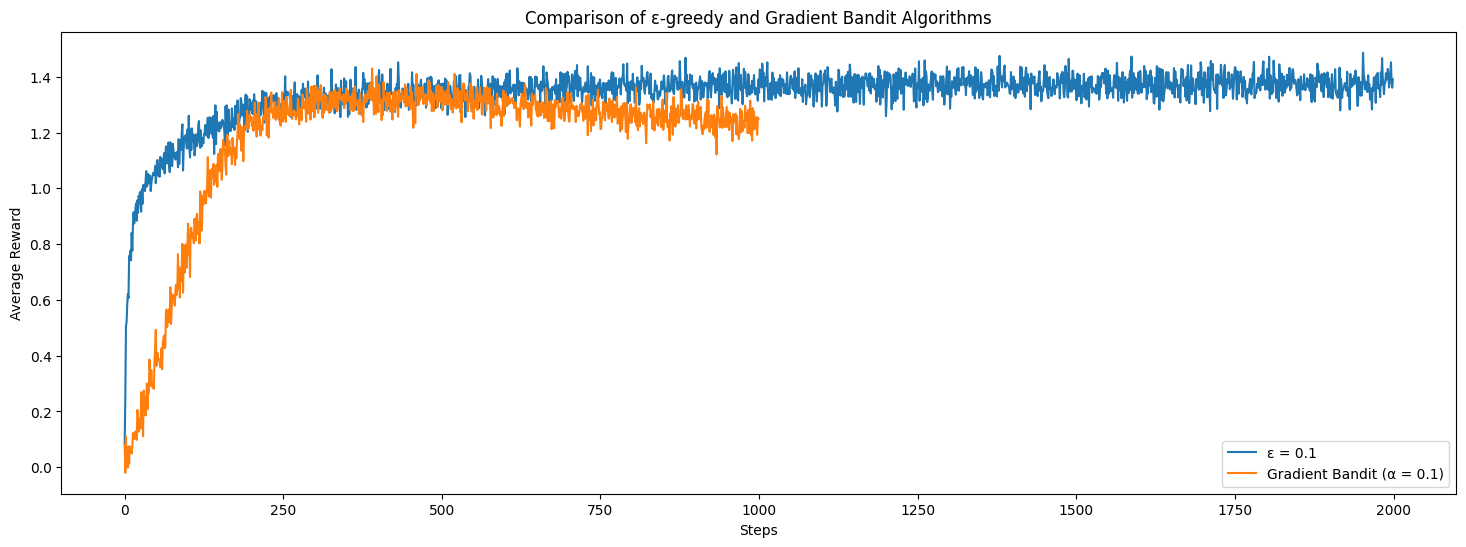

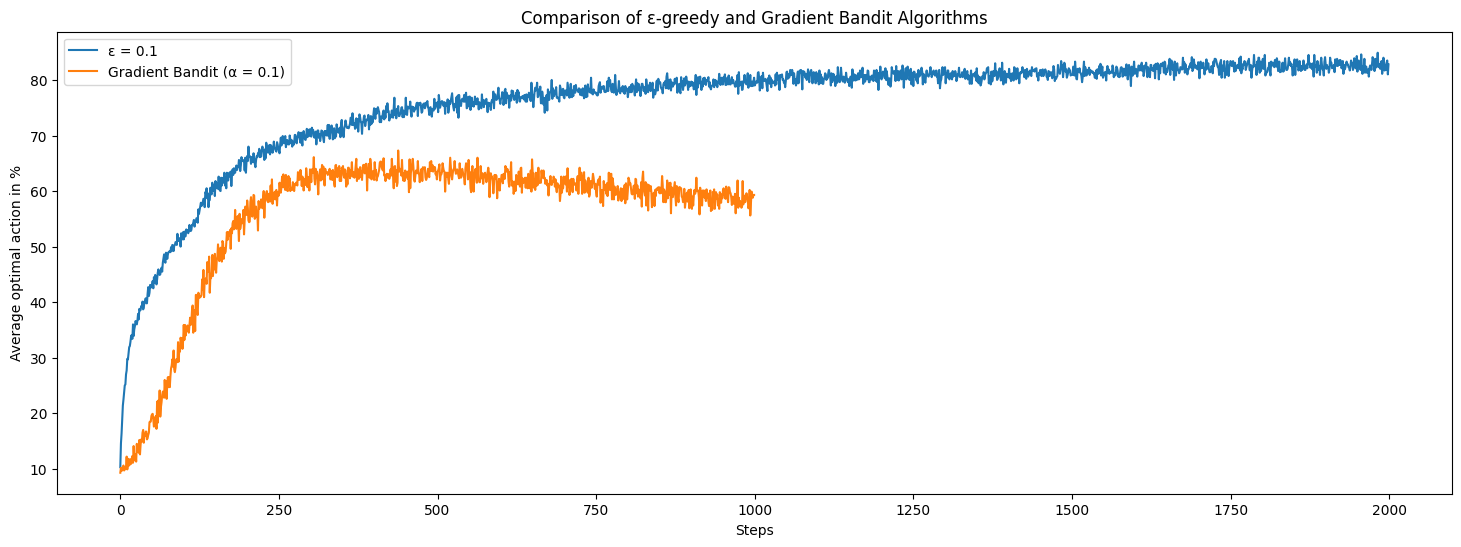

In [7]:
average_reward_gradient_bandit = all_rewards_gradient_bandit.mean(0)
plt.figure(figsize=(18, 6))
plt.plot(average_reward_greedy[:, 2], label=f'ε = 0.1')
plt.plot(average_reward_gradient_bandit - np.ones(steps)*mean, label=f'Gradient Bandit (α = {alpha})')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Comparison of ε-greedy and Gradient Bandit Algorithms')
plt.legend()
plt.show()

average_optimal_arm_gradient_bandit = all_optimal_arm_gradient_bandit.mean(0)
plt.figure(figsize=(18, 6))
plt.plot(average_optimal_arm[:, 2]*100, label=f'ε = 0.1')
plt.plot(average_optimal_arm_gradient_bandit*100, label=f'Gradient Bandit (α = {alpha})')
plt.xlabel('Steps')
plt.ylabel('Average optimal action in %')
plt.title('Comparison of ε-greedy and Gradient Bandit Algorithms')
plt.legend()
plt.show()